# The Deutsch-Josza algorithm
- The DJ algorithm allows us to determine if the function is constant or balanced with just one check, provided we express the function as an **oracle**.
- We know that we want our quantum states to be modified by the application of the function, so that we can figure out if the function is **constant or balanced**. Therefore, we will have to express the **function in the form of an operator**, or a gate. 
- Also, just like all other quantum operators, the gate we make for the function will have to be reversible. An **oracle** is exactly this reversible gate form of the function we want to check.

In [1]:
from random import getrandbits
from qiskit import *
import numpy as np

# STEPS

Here are the steps of the DJ algorithm for a n-bit function:

- Initiate a quantum circuit of n+1 qubits
- Apply an X gate to the last qubit ( for a phase kickback )
- Apply Hadamard transform to all the qubits
- Apply the oracle to the qubits
- Apply H gates to all the qubits 
- Measure 𝑞0. If the probability of the state $|0\rangle ^{\otimes n}$ is non-zero, the oracle is constant. If it is 0, the oracle is balanced.

Notice that we only invoked the oracle (i.e. applied the function) **only once** in this algorithm.

### Defining randomized function

In [25]:
def get_function(n,out = False):
    '''Get the function for the 2^n inputs'''
    inputs = 2**(n) 
    bit = getrandbits(1)
    func = []
    
    # is bit is 0 -> constant 
    if bit == 0:
        if out:
            print("Constant function selected!")
        one = getrandbits(1)
        if one is True:
            func = [1 for _ in range(inputs)]
        else:
            func = [0 for _ in range(inputs)]
        func.insert(0,'constant')
    # is bit is 1 -> balanced
    else:
        if(out):
            print("Balanced function selected!")
        func.append('balanced')
        per = np.random.permutation(inputs)
        for k in per:
            # at even you get 0, at odd you get 1 
            # since even number of elements, always equal
            # zeroes and ones 
            func.append(k%2)
    
    return func

### Defining oracle for n bits 
- Basically just apply an $MCX$ gate whenever f(x) is 1 for an input combination and nothing when it is zero


In [30]:
def get_oracle(function):
    qubits = int(np.log2(len(function)-1))
    qc = QuantumCircuit(qubits+1, qubits,name='Oracle')
    
    # now see what type of function is it
    if(function[0] == 'balanced'):
        function = function[1:]
        
        # wherever it is 0, don't do anyhing
        for i, k in enumerate(function):
            if k == 1:
                
                # first get the binary representation of i
                b = bin(i)[2:]
                b = b.zfill(qubits)[:qubits]
                
                
                # apply X gates
                qc.barrier()
                for j, h in enumerate(b):
                    if(h == '1'):    
                        qc.x(qubits - j -1)
                        
                    
                # apply mcx pertaining to the fact that 
                # bit has to be flipped 
                qc.mcx([i for i in range(qubits)], qubits)
                
                
                # reverse the operation of X application
                for j, h in enumerate(b):
                    if(h == '1'):
                        qc.x(qubits - j - 1)
                qc.barrier()
            else:
                pass
    else:
        
        # get the function
        function = function[1:]
        if(sum(function) == 0): # nothing to be done
            pass
        else:                  # all the qubits need to be inverted 
            qc.x(qubits)
    return qc

## Basis for correct identification
- If the function is balanced, then the **proabability of measuring the state |00...0>** cancels out and we would have atleast one 1 in the measurement of the query register. 

- If the function is constant, then the **probability of the measuring the state |00...0>** is 100% and thus we would have the state *|00...0>* with a probability of 1.

## Testing for n = 3 qubits

Balanced function selected!
Function selected : ['balanced', 1, 1, 0, 0, 0, 1, 1, 0]


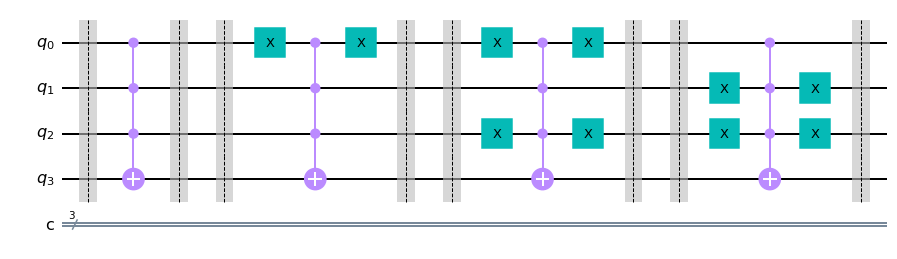

In [31]:
func = get_function(3, out = True)
oracle = get_oracle(func)
print("Function selected :",func)
display(oracle.draw('mpl'))

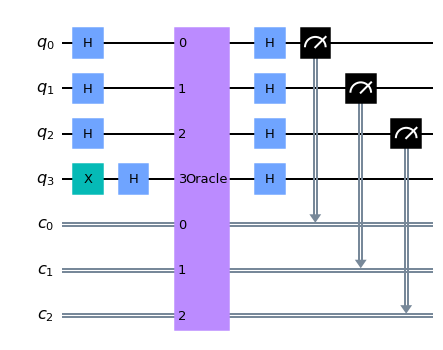

In [28]:
q = QuantumCircuit(4,3)
q.x(3)
q.h(range(4))
q.append(oracle,q.qubits,q.clbits)
q.h(range(4))
q.measure(range(3),range(3))
q.draw('mpl')

{'001': 1}


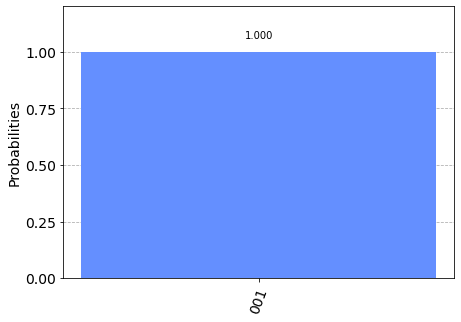

In [29]:
backend = Aer.get_backend('qasm_simulator')
counts = execute(q,backend = backend,shots=1).result().get_counts()
print(counts)
from qiskit.tools.visualization import plot_histogram
plot_histogram(counts)

- This histogram protrays the fact that since **atleast 1 qubit is non-zero in the final query register**,  it shows that the algorithm works and helps us to determine the nature of the function in *a single measurement of the query register*

## Testing for n = 4 qubits


In [22]:
correct , incorrect = 0,0 
for _ in range(100):
    func = get_function(4,False)
    oracle = get_oracle(func)
    # make the circuit
    q = QuantumCircuit(5,4)
    q.x(4)
    q.h([0,1,2,3,4])
    q.append(oracle,q.qubits,q.clbits)
    q.h([0,1,2,3,4])
    q.measure([0,1,2,3],[0,1,2,3])
#     q.draw('mpl')

    backend = Aer.get_backend('qasm_simulator')
    counts = execute(q,backend = backend,shots=1).result().get_counts()
#     print(counts)
    total = 0
    BIT0 = list(counts.keys())[0]
    for k in BIT0:
        total+= int(k)
        
    if(total == 0 and func[0] == 'constant'):
        correct +=1
    elif(total != 0 and func[0] == 'balanced'):
        correct +=1 
    else:
        incorrect +=1

print("Number of correct identifications :",correct)
print("Number of incorrect identifications :",incorrect)

Number of correct identifications : 100
Number of incorrect identifications : 0


## Testing for n = 5 qubits

In [23]:
correct , incorrect = 0,0 
for _ in range(100):
    func = get_function(5,False)
    oracle = get_oracle(func)
    # make the circuit
    q = QuantumCircuit(6,5)
    q.x(5)
    q.h([0,1,2,3,4,5])
    q.append(oracle,q.qubits,q.clbits)
    q.h([0,1,2,3,4,5])
    q.measure([0,1,2,3,4],[0,1,2,3,4])
#     q.draw('mpl')

    backend = Aer.get_backend('qasm_simulator')
    counts = execute(q,backend = backend,shots=1).result().get_counts()
#     print(counts)
    total = 0
    BIT0 = list(counts.keys())[0]
    for k in BIT0:
        total+= int(k)
        
    if(total == 0 and func[0] == 'constant'):
        correct +=1
    elif(total != 0 and func[0] == 'balanced'):
        correct +=1 
    else:
        incorrect +=1

print("Number of correct identifications :",correct)
print("Number of incorrect identifications :",incorrect)

Number of correct identifications : 100
Number of incorrect identifications : 0


## Testing for n = 6 qubits

In [24]:
correct , incorrect = 0,0 
for _ in range(100):
    func = get_function(6,False)
    oracle = get_oracle(func)
    # make the circuit
    q = QuantumCircuit(7,6)
    q.x(6)
    q.h([0,1,2,3,4,5,6])
    q.append(oracle,q.qubits,q.clbits)
    q.h([0,1,2,3,4,5,6])
    q.measure([0,1,2,3,4,5],[0,1,2,3,4,5])
#     q.draw('mpl')

    backend = Aer.get_backend('qasm_simulator')
    counts = execute(q,backend = backend,shots=1).result().get_counts()
#     print(counts)
    total = 0
    BIT0 = list(counts.keys())[0]
    
    for k in BIT0:
        total+= int(k)
        
    if(total == 0 and func[0] == 'constant'):
        correct +=1
    elif(total != 0 and func[0] == 'balanced'):
        correct +=1 
    else:
        incorrect +=1

print("Number of correct identifications :",correct)
print("Number of incorrect identifications :",incorrect)

Number of correct identifications : 100
Number of incorrect identifications : 0
